In [47]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, RepeatedKFold, RepeatedStratifiedKFold, StratifiedKFold

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE

import sklearn.metrics as metrics

# Herramientas
import tools as t

import warnings

warnings.filterwarnings("ignore")

In [79]:
df = pd.read_csv("data/hospital_train.csv")

##### PASO 1
column_names = pd.read_csv("data/columns_meaning.csv", index_col = 0)
column_names_dict = column_names.to_dict()
df.columns = column_names_dict["Description"].values()

##### PASO 2
# Outliers
df = df[df["Number of Extra rooms available in the Hospital"] <= 7]
df = df[df["Number of Visitors with the patient"] <= 10]
df = df[df["Deposit at the Admission Time"] <= 10000]

##### PASO 3
# Paso las variables nominales a dummies
df = pd.get_dummies(df, prefix = ["hospital_type", "hospital_city", "hospital_region", "department", "ward_type", "ward_facility"], columns = ["Unique code for the type of Hospital", "City Code of the Hospital", "Region Code of the Hospital", "Department overlooking the case", "Code for the Ward type", "Code for the Ward Facility"])


##### PASO 4
# Admission Type registered by the Hospital
dict_1 = {
    "Emergency" : 1,
    "Trauma" : 2,
    "Urgent" : 3
}

# Severity of the illness recorded at the time of admission
dict_2 = {
    "Minor" : 1,
    "Moderate" : 2,
    "Extreme" : 3
}

# Age of the patient
dict_3 = {
    "0-10" : 1,
    "11-20" : 2,
    "21-30" : 3,
    "31-40" : 4,
    "41-50" : 5,
    "51-60" : 6,
    "61-70" : 7,
    "71-80" : 8,
    "81-90" : 9,
    "91-100" : 10,
}

# Stay Days by the patient
dict_4 = {
    "0-10" : 1,
    "11-20" : 2,
    "21-30" : 3,
    "31-40" : 4,
    "41-50" : 5,
    "51-60" : 6,
    "61-70" : 7,
    "71-80" : 8,
    "81-90" : 9,
    "91-100" : 10,
    "More than 100 Days" : 11
}

dicts = [dict_1, dict_2, dict_3, dict_4]

columns = ["Admission Type registered by the Hospital", "Severity of the illness recorded at the time of admission", "Age of the patient", "Stay Days by the patient"]

df = t.column_mapper(df, columns, dicts)


##### Paso 5
norm_atributtes = ["Deposit at the Admission Time"]

pipeline = ColumnTransformer([("norm", StandardScaler(), norm_atributtes)])

df2 = pd.DataFrame(pipeline.fit_transform(df), columns = norm_atributtes)

for column in norm_atributtes:
    df[column] = df2[column]


##### PASO 6
# Condition of Bed in the Ward 
#df.iloc[:, 3] = df.iloc[:, 3].fillna(df.iloc[:, 3].mode()[0])
# City Code for the patient
#df.iloc[:, 5] = df.iloc[:, 5].fillna(df.iloc[:, 5].mode()[0])
for column in df.columns:
    df.loc[:, column] = df.loc[:, column].fillna(df.loc[:, column].mode()[0])


##### Paso 7
#df = df[(df["Stay Days by the patient"] == 2) | (df["Stay Days by the patient"] == 3) | (df["Stay Days by the patient"] == 4)]
df.set_index("Case_ID registered in Hospital", inplace = True)
df = df.drop(["Unique Patient Id", "City Code for the patient", "hospital_city_6"], axis = 1)

df.head()

,Unique code for the Hospital,Number of Extra rooms available in the Hospital,Condition of Bed in the Ward,Admission Type registered by the Hospital,Severity of the illness recorded at the time of admission,Number of Visitors with the patient,Age of the patient,Deposit at the Admission Time,Stay Days by the patient,hospital_type_a,...,ward_type_R,ward_type_S,ward_type_T,ward_type_U,ward_facility_A,ward_facility_B,ward_facility_C,ward_facility_D,ward_facility_E,ward_facility_F
Case_ID registered in Hospital,,,,,,,,,,,,,,,,,,,,,
161528,6,2,4.0,3,2,2,3,-1.932209,1,1,...,1,0,0,0,0,0,0,0,0,1
159472,23,4,2.0,2,2,4,6,-0.359586,3,1,...,0,0,0,0,0,0,0,0,0,1
309765,2,2,3.0,3,2,2,8,-0.289422,2,0,...,0,1,0,0,0,0,0,0,0,1
279614,32,3,4.0,1,2,4,2,2.170082,6,0,...,0,1,0,0,0,1,0,0,0,0
147791,14,3,2.0,3,2,2,6,-1.388667,6,1,...,0,1,0,0,0,0,0,0,1,0


In [80]:
df.describe()

,Unique code for the Hospital,Number of Extra rooms available in the Hospital,Condition of Bed in the Ward,Admission Type registered by the Hospital,Severity of the illness recorded at the time of admission,Number of Visitors with the patient,Age of the patient,Deposit at the Admission Time,Stay Days by the patient,hospital_type_a,...,ward_type_R,ward_type_S,ward_type_T,ward_type_U,ward_facility_A,ward_facility_B,ward_facility_C,ward_facility_D,ward_facility_E,ward_facility_F
count,98757.000000,98757.000000,98757.000000,98757.000000,98757.000000,98757.00000,98757.000000,98757.000000,98757.000000,98757.000000,...,98757.000000,98757.000000,98757.000000,98757.000000,98757.000000,98757.000000,98757.000000,98757.000000,98757.000000,98757.000000
mean,18.326914,3.176281,2.618640,1.779530,1.906143,3.20596,5.127424,-0.004507,3.660905,0.449042,...,0.404569,0.244783,0.004577,0.000030,0.087062,0.109187,0.111891,0.162854,0.172879,0.356127
std,8.629186,1.119551,0.873698,0.690183,0.662411,1.48478,1.887137,0.994560,2.097565,0.497399,...,0.490811,0.429960,0.067498,0.005512,0.281928,0.311876,0.315234,0.369235,0.378144,0.478856
min,1.000000,0.000000,1.000000,1.000000,1.000000,0.00000,1.000000,-2.873350,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,2.000000,2.000000,1.000000,1.000000,2.00000,4.000000,-0.634631,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,19.000000,3.000000,3.000000,2.000000,2.000000,3.00000,5.000000,-0.140673,3.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,26.000000,4.000000,3.000000,2.000000,2.000000,4.00000,6.000000,0.484260,4.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,32.000000,7.000000,4.000000,3.000000,3.000000,10.00000,10.000000,4.782076,11.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98757 entries, 161528 to 69647
Data columns (total 46 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   Unique code for the Hospital                               98757 non-null  int64  
 1   Number of Extra rooms available in the Hospital            98757 non-null  int64  
 2   Condition of Bed in the Ward                               98757 non-null  float64
 3   Admission Type registered by the Hospital                  98757 non-null  int64  
 4   Severity of the illness recorded at the time of admission  98757 non-null  int64  
 5   Number of Visitors with the patient                        98757 non-null  int64  
 6   Age of the patient                                         98757 non-null  int64  
 7   Deposit at the Admission Time                              98757 non-null  float64
 8   S

In [82]:
# Independent variables
X = np.array(df.drop("Stay Days by the patient", axis = 1))

# Dependent variable
y = np.array(df["Stay Days by the patient"])

# Balancing data
ratio = 1.55
resample = {
    1 : 7427,
    2 : 24476,
    3 : 27452,
    4 : round(17311 * ratio),
    5 : 3668,
    6 : 10984,
    7 : 857,
    8 : 3297,
    9 : 1470,
    10 : 908,
    11 : 2150
}
sm = SMOTE(sampling_strategy = resample, random_state = 42, n_jobs = -1)
#sm = SMOTE(random_state = 42, n_jobs = -1)

#X_sm, y_sm = sm.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)
#X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size = .2, random_state = 42)

#X_train, y_train = sm.fit_resample(X_train, y_train)

# Cross validation
#kfold = RepeatedKFold(n_splits = 10, n_repeats = 1, random_state = 42)
kfold = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1, random_state = 42)

# Model
model = LogisticRegression(max_iter = 1000, n_jobs = -1)
#model2 = RandomForestClassifier(n_jobs = -1, random_state = 42)
#model = LinearSVC(random_state = 42, max_iter = 1000)
#model = KNeighborsClassifier(n_neighbors = 5, n_jobs = -1)
#model = GradientBoostingClassifier(random_state = 42)

#estimators = [("logistic_regression", model1), ("random_forest", model2)]
#model = VotingClassifier(estimators = estimators, n_jobs = -1)

In [83]:
train_scores = []
val_scores = []
count = 1

for (train, val) in kfold.split(X_train, y_train):

    #print(train)
    #print(val)

    # Train-Validation sets
    x_t, y_t = X_train[train], y_train[train]
    x_v, y_v = X_train[val], y_train[val]


    # Internal structure
    y_t_unique, y_t_counts = np.unique(y_t, return_counts=True)
    y_v_unique, y_v_counts = np.unique(y_v, return_counts=True)

    # Training
    model.fit(x_t, y_t)

    # Scores
    train_score = model.score(x_t, y_t)
    val_score = model.score(x_v, y_v)

    train_scores.append(train_score)
    val_scores.append(val_score)

    print(f"Model {count}")
    #print("-" * 25)
    #print("Set structure:")
    #print("Train structure:", dict(zip(y_t_unique, y_t_counts / len(y_t))))
    #print("Validation structure:", dict(zip(y_v_unique, y_v_counts / len(y_v))))
    #print("-" * 25)
    print("train score:", train_score)
    print("test score:", val_score)
    print("#" * 75)

    count += 1

Model 1
train score: 0.38463377587758774
test score: 0.37033286925705605
###########################################################################
Model 2
train score: 0.3839024527452745
test score: 0.38438172383242625
###########################################################################
Model 3
train score: 0.38288985148514854
test score: 0.378559675990381
###########################################################################
Model 4
train score: 0.38318519351935193
test score: 0.38096443488166054
###########################################################################
Model 5
train score: 0.38314300180018
test score: 0.382356663713454
###########################################################################
Model 6
train score: 0.3842627100766472
test score: 0.3782278481012658
###########################################################################
Model 7
train score: 0.3838689262358484
test score: 0.3841772151898734
#############################################

plt.plot(train_scores)
plt.plot(val_scores)
plt.legend(["train scores", "val scores"])

In [84]:
# Training with full train_data
model.fit(X_train, y_train)

# Internal structure
y_train_unique, y_train_counts = np.unique(y_train, return_counts=True)
y_test_unique, y_test_counts = np.unique(y_test, return_counts=True)

# Scores
train_score_ = model.score(X_train, y_train)
test_score_ = model.score(X_test, y_test)

# Prediction
prediction = model.predict(X_test)

# Confusion matrix
cm = metrics.confusion_matrix(y_test, prediction)

print("Train set model:")
print("#" * 50)
#print("\nTrain structure:", dict(zip(y_train_unique, y_train_counts / len(y_train) * 100)))
print("Train score:", train_score_)
print("#" * 50)
print("\nTest set model:")
#print("Test structure:", dict(zip(y_test_unique, y_test_counts / len(y_test) * 100)))
print("Test score:", test_score_)
print("#" * 50)
print("\nConfusion matrix\n", cm)

Train set model:
##################################################
Train score: 0.3833175115499019
##################################################

Test set model:
Test score: 0.3830498177399757
##################################################

Confusion matrix
 [[   0  722  743   40    0    2    0    0    0    0    0]
 [   0 2230 2217  252    0  181    0    0    0    0    2]
 [   0 1651 3570  191    0   78    0    0    0    0    7]
 [   0  700 1404  637    0  667    0    0    0    0    4]
 [   0  154  446   54    0   49    0    0    0    0    2]
 [   0  195  310  574    0 1044    0    0    0    0   16]
 [   0   30   92   24    0   21    0    0    0    0    4]
 [   0   57   65  185    0  325    0    0    1    0   24]
 [   0   12   12   20    0  215    0    0    0    0   19]
 [   0   10   24   41    0   78    0    0    3    0   16]
 [   0   10   37   29    0  166    0    0    5    0   85]]


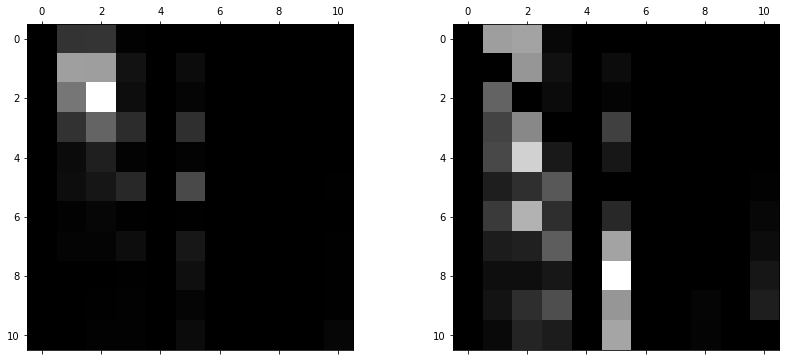

In [85]:
row_sums = cm.sum(axis = 1, keepdims = True)
norm_cm = cm / row_sums
np.fill_diagonal(norm_cm, 0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))

ax1.matshow(cm, cmap = plt.cm.gray)
ax2.matshow(norm_cm, cmap = plt.cm.gray)

plt.show()

plt.figure(figsize = (12, 12))

sns.heatmap(cm / len(y_test), annot = True, linewidths = .5, square = True, cmap = "Blues_r")

plt.xticks(range(0, 11), range(1, 12))
plt.yticks(range(0, 11), range(1, 12))

plt.xlabel("Actual label")
plt.ylabel("Predicted label")

plt.title(f"Test score: {test_score_}")

plt.show()

# Submission

In [86]:
column_names = pd.read_csv("data/columns_meaning.csv", index_col = 0)
column_names

,Description
Column,
0,Case_ID registered in Hospital
1,Unique code for the Hospital
2,Unique code for the type of Hospital
3,City Code of the Hospital
4,Region Code of the Hospital
5,Number of Extra rooms available in the Hospital
6,Department overlooking the case
7,Code for the Ward type
8,Code for the Ward Facility


In [94]:
X_pred = pd.read_csv("data/hospital_test.csv")

##### PASO 1
column_names = pd.read_csv("data/columns_meaning.csv", index_col = 0)[:-1]
column_names_dict = column_names.to_dict()
X_pred.columns = column_names_dict["Description"].values()

##### PASO 2
# Outliers
#df = df[df["Number of Extra rooms available in the Hospital"] <= 7]
#df = df[df["Number of Visitors with the patient"] <= 10]
#df = df[df["Deposit at the Admission Time"] <= 10000]

##### PASO 3
# Paso las variables nominales a dummies
X_pred = pd.get_dummies(X_pred, prefix = ["hospital_type", "hospital_city", "hospital_region", "department", "ward_type", "ward_facility"], columns = ["Unique code for the type of Hospital", "City Code of the Hospital", "Region Code of the Hospital", "Department overlooking the case", "Code for the Ward type", "Code for the Ward Facility"])


##### PASO 4
# Admission Type registered by the Hospital
dict_1 = {
    "Emergency" : 1,
    "Trauma" : 2,
    "Urgent" : 3
}

# Severity of the illness recorded at the time of admission
dict_2 = {
    "Minor" : 1,
    "Moderate" : 2,
    "Extreme" : 3
}

# Age of the patient
dict_3 = {
    "0-10" : 1,
    "11-20" : 2,
    "21-30" : 3,
    "31-40" : 4,
    "41-50" : 5,
    "51-60" : 6,
    "61-70" : 7,
    "71-80" : 8,
    "81-90" : 9,
    "91-100" : 10,
}

# Stay Days by the patient
dict_4 = {
    "0-10" : 1,
    "11-20" : 2,
    "21-30" : 3,
    "31-40" : 4,
    "41-50" : 5,
    "51-60" : 6,
    "61-70" : 7,
    "71-80" : 8,
    "81-90" : 9,
    "91-100" : 10,
    "More than 100 Days" : 11
}

dicts = [dict_1, dict_2, dict_3]

columns = ["Admission Type registered by the Hospital", "Severity of the illness recorded at the time of admission", "Age of the patient"]

X_pred = t.column_mapper(X_pred, columns, dicts)


##### Paso 5
norm_atributtes = ["Deposit at the Admission Time"]

pipeline = ColumnTransformer([("norm", StandardScaler(), norm_atributtes)])

X_pred_2 = pd.DataFrame(pipeline.fit_transform(X_pred), columns = norm_atributtes)

for column in norm_atributtes:
    X_pred[column] = X_pred_2[column]


##### PASO 6
# Condition of Bed in the Ward 
#df.iloc[:, 3] = df.iloc[:, 3].fillna(df.iloc[:, 3].mode()[0])
# City Code for the patient
#df.iloc[:, 5] = df.iloc[:, 5].fillna(df.iloc[:, 5].mode()[0])
for column in X_pred.columns:
    X_pred.loc[:, column] = X_pred.loc[:, column].fillna(X_pred.loc[:, column].mode()[0])


##### Paso 7
#df = df[(df["Stay Days by the patient"] == 2) | (df["Stay Days by the patient"] == 3) | (df["Stay Days by the patient"] == 4)]
X_pred.set_index("Case_ID registered in Hospital", inplace = True)
X_pred = X_pred.drop(["Unique Patient Id", "City Code for the patient", "hospital_city_6"], axis = 1)

X_pred.head()

,Unique code for the Hospital,Number of Extra rooms available in the Hospital,Condition of Bed in the Ward,Admission Type registered by the Hospital,Severity of the illness recorded at the time of admission,Number of Visitors with the patient,Age of the patient,Deposit at the Admission Time,hospital_type_a,hospital_type_b,...,ward_type_R,ward_type_S,ward_type_T,ward_type_U,ward_facility_A,ward_facility_B,ward_facility_C,ward_facility_D,ward_facility_E,ward_facility_F
Case_ID registered in Hospital,,,,,,,,,,,,,,,,,,,,,
314114,19,4,2.0,1,1,2,5,-0.095923,1,0,...,0,1,0,0,0,0,1,0,0,0
208989,15,3,2.0,2,2,3,4,0.780214,0,0,...,0,1,0,0,0,0,0,0,0,1
305872,17,4,4.0,1,1,3,8,0.166185,0,0,...,1,0,0,0,0,0,0,0,1,0
266099,3,4,2.0,3,3,4,4,-1.492611,0,0,...,1,0,0,0,1,0,0,0,0,0
13228,6,4,1.0,1,1,3,3,-0.223311,1,0,...,1,0,0,0,0,0,0,0,0,1


In [95]:
dict_5 = {
    1 : "0-10",
    2 : "11-20",
    3 : "21-30",
    4 : "31-40",
    5 : "41-50",
    6 : "51-60",
    7 : "61-70",
    8 : "71-80",
    9 : "81-90",
    10 : "91-100",
    11 : "More than 100 Days"
}

to_submit = X_pred
to_submit["prediction"] = model.predict(X_pred)

to_submit = to_submit.reset_index()
to_submit = to_submit[["Case_ID registered in Hospital", "prediction"]]
#to_submit.name = "days"
to_submit.columns = ["id", "days"]
to_submit.days = to_submit.days.map(dict_5)
#to_submit = to_submit.map(dict_5)
to_submit.set_index("id", inplace = True)

to_submit.head()

,days
id,
314114,11-20
208989,31-40
305872,11-20
266099,31-40
13228,21-30


In [96]:
to_submit.to_csv("submissions/submission5.csv")